In [63]:
# -----------------------------
# Load Packages
# -----------------------------
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from scipy import sparse

In [64]:
# -----------------------------
# Load the datasets
# -----------------------------

# Connor's file path
#train_df = pd.read_csv(r'C:/Users/conre/OneDrive/Desktop/Coding Folder/.csv files/project_adult.csv')
#valid_df = pd.read_csv(r'C:/Users/conre/OneDrive/Desktop/Coding Folder/.csv files/project_validation_inputs.csv')

# Victoria's file path
train_df = pd.read_csv(r'project_adult.csv')
valid_df = pd.read_csv(r'project_validation_inputs.csv')

# Drop the saved index column if present
for df in (train_df, valid_df):
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
# Show first 10 rows of original training data
print("\nOriginal Training Data (first 10 rows):")
print(train_df.head(10))




Original Training Data (first 10 rows):
   age         workclass  fnlwgt     education  education-num  \
0   33         Local-gov  198183     Bachelors             13   
1   36           Private   86459     Assoc-voc             11   
2   58  Self-emp-not-inc  203039           9th              5   
3   21           Private  180190     Assoc-voc             11   
4   27           Private  279872  Some-college             10   
5   44           Private  175485     Bachelors             13   
6   33           Private   67006          10th              6   
7   62  Self-emp-not-inc   75478     Bachelors             13   
8   20           Private  374116       HS-grad              9   
9   33           Private   23871       HS-grad              9   

       marital-status         occupation    relationship   race     sex  \
0       Never-married     Prof-specialty   Not-in-family  White  Female   
1  Married-civ-spouse    Exec-managerial         Husband  White    Male   
2           Separa

In [65]:
# Separate features and target (keep ALL rows—both <=50K and >50K)
X_train_raw = train_df.drop(columns=["income"])
y_raw = train_df["income"]            # kept for later parts; Part 1 focuses on X
X_valid_raw = valid_df.copy()         # validation has no label

# Identify numeric and categorical feature columns
numeric_cols = X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train_raw.select_dtypes(include=["object"]).columns.tolist()

print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")



Numeric columns (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


# Part 1a: Handle the Missing Values

In [66]:
# Convert literal '?' placeholders to true NaN so imputers can work
for df in (X_train_raw, X_valid_raw):
    df.replace("?", np.nan, inplace=True)

# Impute numeric columns with median
num_imputer = SimpleImputer(strategy="median")
X_train_num_imp = pd.DataFrame(
    num_imputer.fit_transform(X_train_raw[numeric_cols]),
    columns=numeric_cols,
    index=X_train_raw.index
)
X_valid_num_imp = pd.DataFrame(
    num_imputer.transform(X_valid_raw[numeric_cols]),
    columns=numeric_cols,
    index=X_valid_raw.index
)

# Impute categorical columns with most frequent (mode)
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_imp = pd.DataFrame(
    cat_imputer.fit_transform(X_train_raw[categorical_cols]),
    columns=categorical_cols,
    index=X_train_raw.index
)
X_valid_cat_imp = pd.DataFrame(
    cat_imputer.transform(X_valid_raw[categorical_cols]),
    columns=categorical_cols,
    index=X_valid_raw.index
)

# Reassemble the imputed train/valid feature DataFrames (still raw types)
X_train_imp = pd.concat([X_train_num_imp, X_train_cat_imp], axis=1)
X_valid_imp = pd.concat([X_valid_num_imp, X_valid_cat_imp], axis=1)

print("\nAFTER Part 1a (imputed, not encoded/scaled) — first 10 rows:")
print(X_train_imp.head(10)[numeric_cols + categorical_cols][:10])



AFTER Part 1a (imputed, not encoded/scaled) — first 10 rows:
    age    fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0  33.0  198183.0           13.0           0.0           0.0            50.0   
1  36.0   86459.0           11.0           0.0        1887.0            50.0   
2  58.0  203039.0            5.0           0.0           0.0            40.0   
3  21.0  180190.0           11.0           0.0           0.0            46.0   
4  27.0  279872.0           10.0           0.0           0.0            40.0   
5  44.0  175485.0           13.0           0.0           0.0            12.0   
6  33.0   67006.0            6.0           0.0           0.0            45.0   
7  62.0   75478.0           13.0           0.0           0.0            40.0   
8  20.0  374116.0            9.0           0.0           0.0            40.0   
9  33.0   23871.0            9.0           0.0           0.0            30.0   

          workclass     education      marital-status    

# Part 1b: Encode categorical features (One-Hot)

In [67]:
# Create OneHotEncoder in a version-robust way:
# - Newer sklearn: use 'sparse_output'
# - Older sklearn: fall back to 'sparse'
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

# Fit/transform categorical blocks (still using the imputed DataFrames from Part 1a)
cat_train_enc = ohe.fit_transform(X_train_cat_imp)   # may be sparse or dense depending on version/args
cat_valid_enc = ohe.transform(X_valid_cat_imp)

# Ensure we have CSR sparse matrices for consistent downstream hstack
from scipy import sparse as sp
if not sp.issparse(cat_train_enc):
    cat_train_enc = sp.csr_matrix(cat_train_enc)
if not sp.issparse(cat_valid_enc):
    cat_valid_enc = sp.csr_matrix(cat_valid_enc)

# Get encoded categorical feature names (e.g., 'workclass_Private', ...)
cat_feature_names_raw = ohe.get_feature_names_out(input_features=categorical_cols)
cat_feature_names = [f"cat__{n}" for n in cat_feature_names_raw]

# Numeric part (from Part 1a) stays unscaled for now (we scale in Part 1c)
num_train = X_train_num_imp.values
num_valid = X_valid_num_imp.values
num_feature_names = [f"num__{c}" for c in numeric_cols]

# Combine numeric (dense->sparse) + categorical (sparse) into a single design matrix
X_train_enc_unscaled = sp.hstack(
    [sp.csr_matrix(num_train), cat_train_enc],
    format="csr"
)
X_valid_enc_unscaled = sp.hstack(
    [sp.csr_matrix(num_valid), cat_valid_enc],
    format="csr"
)

feature_names_unscaled = num_feature_names + cat_feature_names

print("\nShape AFTER Part 1b (encoded, unscaled):", X_train_enc_unscaled.shape)

# Preview ONLY the first 10 rows (convert small slice to dense for readability)
X_train_part1b_preview = pd.DataFrame(
    X_train_enc_unscaled[:10].toarray(),
    columns=feature_names_unscaled
)
print("\nAFTER Part 1b (encoded, unscaled) — first 10 rows:")
print(X_train_part1b_preview.head(10))



Shape AFTER Part 1b (encoded, unscaled): (26048, 105)

AFTER Part 1b (encoded, unscaled) — first 10 rows:
   num__age  num__fnlwgt  num__education-num  num__capital-gain  \
0      33.0     198183.0                13.0                0.0   
1      36.0      86459.0                11.0                0.0   
2      58.0     203039.0                 5.0                0.0   
3      21.0     180190.0                11.0                0.0   
4      27.0     279872.0                10.0                0.0   
5      44.0     175485.0                13.0                0.0   
6      33.0      67006.0                 6.0                0.0   
7      62.0      75478.0                13.0                0.0   
8      20.0     374116.0                 9.0                0.0   
9      33.0      23871.0                 9.0                0.0   

   num__capital-loss  num__hours-per-week  cat__workclass_Federal-gov  \
0                0.0                 50.0                         0.0   
1        

# Part 1c: Standardize numerical features

In [68]:
scaler = StandardScaler()
num_train_scaled = scaler.fit_transform(X_train_num_imp.values)  # fit on train only
num_valid_scaled = scaler.transform(X_valid_num_imp.values)

# Re-combine: scaled numeric (dense->sparse) + one-hot categorical (sparse)
X_train_final = sparse.hstack(
    [sparse.csr_matrix(num_train_scaled), cat_train_enc],
    format="csr"
)
X_valid_final = sparse.hstack(
    [sparse.csr_matrix(num_valid_scaled), cat_valid_enc],
    format="csr"
)

feature_names_final = num_feature_names + cat_feature_names

print("\nShape AFTER Part 1c (final preprocessed):", X_train_final.shape)

# Preview ONLY the first 10 rows of the FINAL preprocessed training features
X_train_part1c_preview = pd.DataFrame(
    X_train_final[:10].toarray(),
    columns=feature_names_final
)
print("\nAFTER Part 1c (final preprocessed) — first 10 rows:")
print(X_train_part1c_preview.head(10))



Shape AFTER Part 1c (final preprocessed): (26048, 105)

AFTER Part 1c (final preprocessed) — first 10 rows:
   num__age  num__fnlwgt  num__education-num  num__capital-gain  \
0 -0.408756     0.080051            1.133702          -0.145715   
1 -0.188857    -0.981653            0.357049          -0.145715   
2  1.423734     0.126197           -1.972910          -0.145715   
3 -1.288351    -0.090935            0.357049          -0.145715   
4 -0.848554     0.856334           -0.031277          -0.145715   
5  0.397539    -0.135646            1.133702          -0.145715   
6 -0.408756    -1.166513           -1.584583          -0.145715   
7  1.716932    -1.086004            1.133702          -0.145715   
8 -1.361651     1.751927           -0.419604          -0.145715   
9 -0.408756    -1.576421           -0.419604          -0.145715   

   num__capital-loss  num__hours-per-week  cat__workclass_Federal-gov  \
0          -0.217998             0.779460                         0.0   
1      

# Part 1: Other

In [69]:
# Binarize the incomes
y = y_raw.apply(lambda x: 1 if x == '>50K' else 0)

print(y.head())

0    1
1    1
2    0
3    0
4    0
Name: income, dtype: int64


In [70]:
# Convert to a data frame

X = pd.DataFrame(
    X_train_final[:26048].toarray(),
    columns=feature_names_final
)

y = pd.DataFrame(
    y[:26048],
    columns=['income']
)

X_valid = pd.DataFrame(
    X_valid_final[:26048].toarray(),
    columns=feature_names_final
)

# Check types
#print(type(X))
#print(type(y))

# (Perceptron) Part 2a : Train the model

In [71]:
# Implement the Perceptron class
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)

        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)


In [72]:
# Split into train and test
X_train_perceptron, X_test_perceptron, y_train_perceptron, y_test_perceptron = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Convert to numpy.ndarray to match the data type needed for perceptron code

# Convert X_train_perceptron to numpy.ndarray
X_train_perceptron = np.array(X_train_perceptron)

# Convert X_test_perceptron to numpy.ndarray
X_test_perceptron -= np.array(X_test_perceptron)

# Convert y_train_perceptron to numpy.ndarray
y_train_perceptron = y_train_perceptron['income'].to_list()
y_train_perceptron = np.array(y_train_perceptron)

# Convert y_test_perceptron to numpy.ndarray
y_test_perceptron = y_test_perceptron['income'].to_list()
y_test_perceptron = np.array(y_test_perceptron)

# Convert X_valid to numpy.ndarray
X_valid_perceptron = np.array(X_valid)

# Check type
#type(X_perceptron)

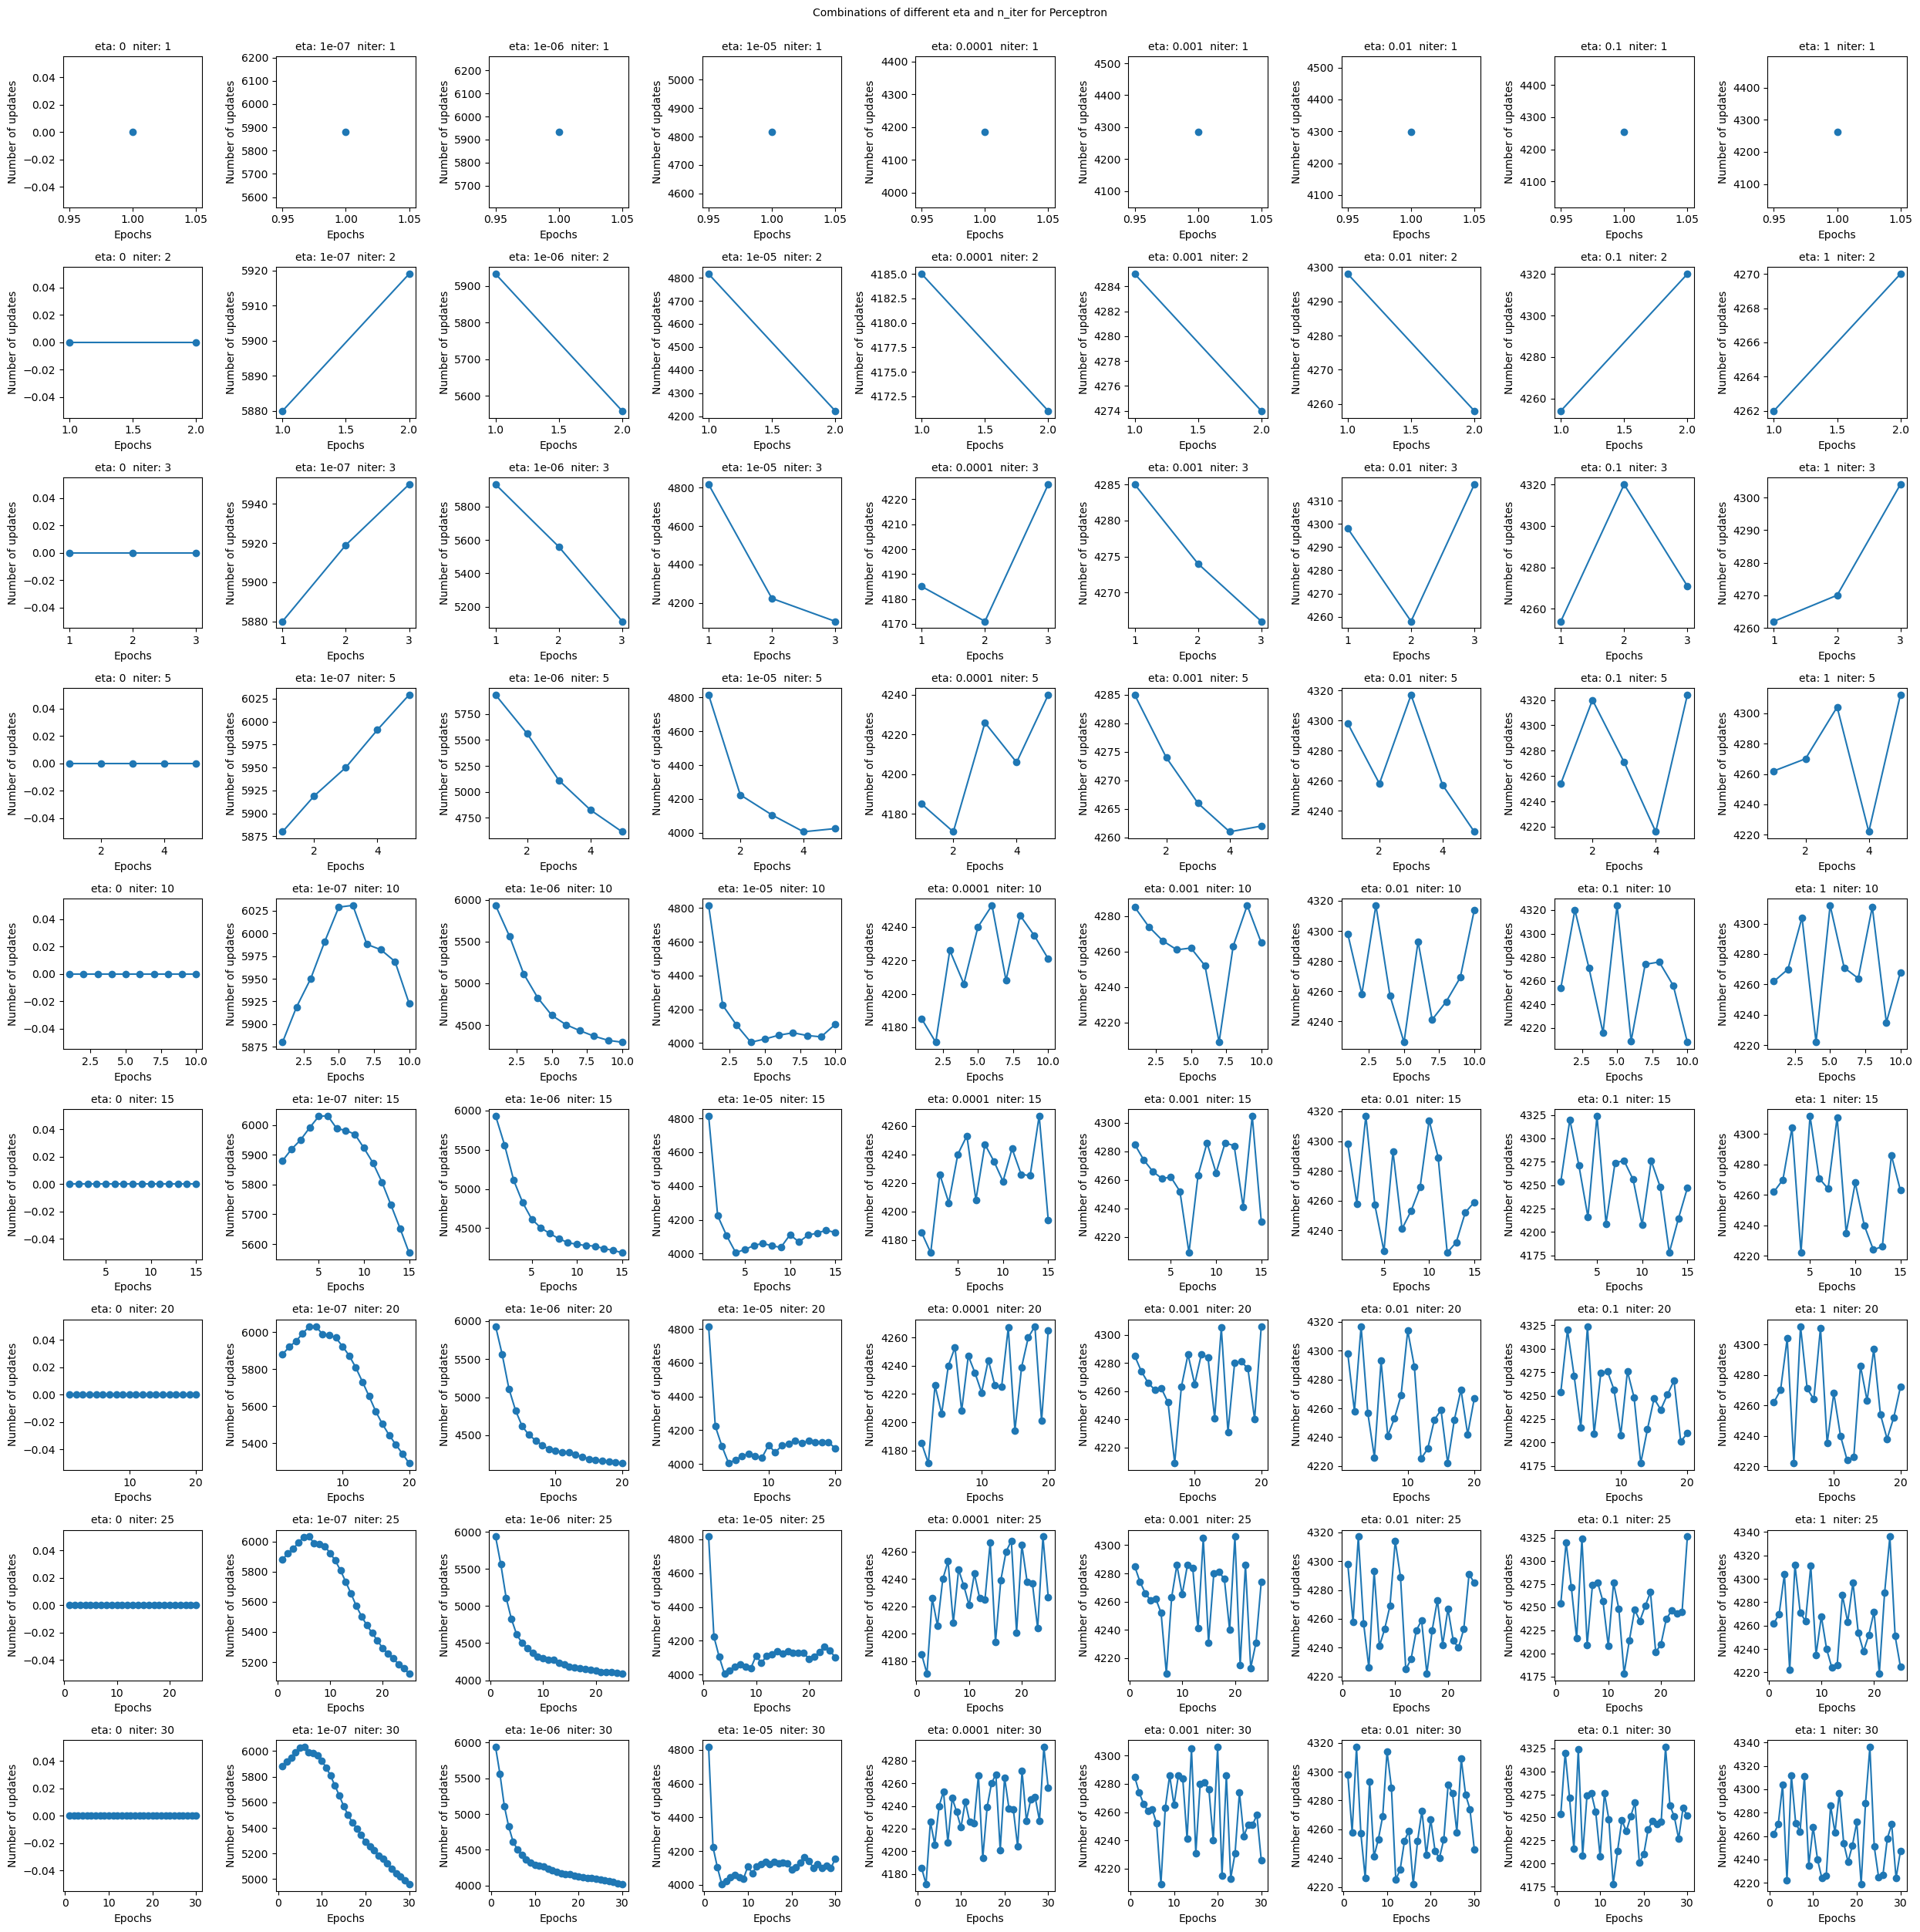

In [143]:
# Find good value of eta and n_iter
fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(25, 25))

list_eta = [0, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
list_niter = [1, 2, 3, 5, 10, 15, 20, 25, 30]

fig.suptitle("Combinations of different eta and n_iter for Perceptron", fontsize=10, y=1)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta= e_temp, random_state=42).fit(X_train_perceptron, y_train_perceptron)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

plt.tight_layout()
plt.show()

In [144]:
# Compare the accuracy with eta 0.000001 and different n_iter

# n_iter 15
ppn1 = Perceptron(eta=0.000001, n_iter=15, random_state=1)
ppn1.fit(X_train_perceptron, y_train_perceptron)
ppn1_pred = ppn1.predict(X_test_perceptron)

# n_iter 20
ppn2 = Perceptron(eta=0.000001, n_iter=20, random_state=1)
ppn2.fit(X_train_perceptron, y_train_perceptron)
ppn2_pred = ppn2.predict(X_test_perceptron)


print(f"Perceptron accuracy with n_iter 15 and eta 0.000001: {accuracy_score(y_test_perceptron, ppn1_pred):.4f}")
print(f"Perceptron accuracy with n_iter 20 and eta 0.000001: {accuracy_score(y_test_perceptron, ppn2_pred):.4f}")

Perceptron accuracy with n_iter 15 and eta 0.000001: 0.7685
Perceptron accuracy with n_iter 20 and eta 0.000001: 0.7685


# (Perceptron) Part 2b: Plot the missclassification

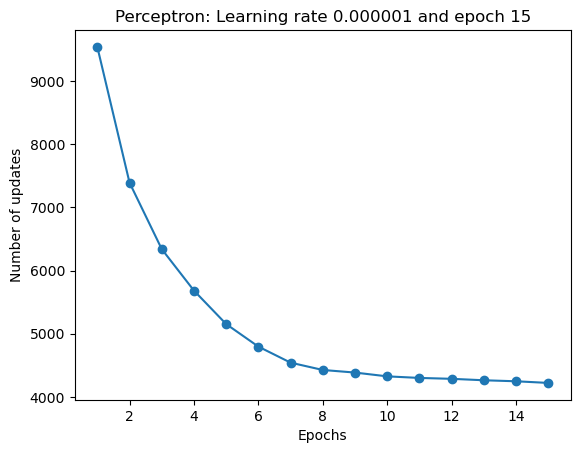

In [146]:
# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn1.errors_) + 1), ppn1.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.title('Perceptron: Learning rate 0.000001 and epoch 15')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

# (Perceptron) Part 2c: Find the accuracy 

In [147]:
print(f"Perceptron accuracy with n_iter 15 and eta 0.000001: {accuracy_score(y_test_perceptron, ppn1_pred):.4f}")

Perceptron accuracy with n_iter 15 and eta 0.000001: 0.7685


# (Perceptron) Part 2d: Use best performing models to predict outputs for the validation

In [148]:
# Output the predictions for the validation
y_valid_pred_perceptron = ppn1.predict(X_valid_perceptron)

In [149]:
# Save validation prediction outputs to csv
#y_valid_pred_perceptron_df = pd.DataFrame(y_valid_pred_perceptron)
#y_valid_pred_perceptron_df.to_csv("Group_10_Perceptron_PredictedOutputs.csv")

# (Adaline) Part 2a: Train the model

In [79]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.


    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [80]:
# Split into train and test
X_train_adaline, X_test_adaline, y_train_adaline, y_test_adaline = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid_adaline = X_valid.copy()

In [81]:
# Create variables to use in functions later
X_train_adaline_col = X_train_adaline.loc[:,['num__age',
 'num__fnlwgt',
 'num__education-num',
 'num__capital-gain',
 'num__capital-loss',
 'num__hours-per-week',
 'cat__workclass_Federal-gov',
 'cat__workclass_Local-gov',
 'cat__workclass_Never-worked',
 'cat__workclass_Private',
 'cat__workclass_Self-emp-inc',
 'cat__workclass_Self-emp-not-inc',
 'cat__workclass_State-gov',
 'cat__workclass_Without-pay',
 'cat__education_10th',
 'cat__education_11th',
 'cat__education_12th',
 'cat__education_1st-4th',
 'cat__education_5th-6th',
 'cat__education_7th-8th',
 'cat__education_9th',
 'cat__education_Assoc-acdm',
 'cat__education_Assoc-voc',
 'cat__education_Bachelors',
 'cat__education_Doctorate',
 'cat__education_HS-grad',
 'cat__education_Masters',
 'cat__education_Preschool',
 'cat__education_Prof-school',
 'cat__education_Some-college',
 'cat__marital-status_Divorced',
 'cat__marital-status_Married-AF-spouse',
 'cat__marital-status_Married-civ-spouse',
 'cat__marital-status_Married-spouse-absent',
 'cat__marital-status_Never-married',
 'cat__marital-status_Separated',
 'cat__marital-status_Widowed',
 'cat__occupation_Adm-clerical',
 'cat__occupation_Armed-Forces',
 'cat__occupation_Craft-repair',
 'cat__occupation_Exec-managerial',
 'cat__occupation_Farming-fishing',
 'cat__occupation_Handlers-cleaners',
 'cat__occupation_Machine-op-inspct',
 'cat__occupation_Other-service',
 'cat__occupation_Priv-house-serv',
 'cat__occupation_Prof-specialty',
 'cat__occupation_Protective-serv',
 'cat__occupation_Sales',
 'cat__occupation_Tech-support',
 'cat__occupation_Transport-moving',
 'cat__relationship_Husband',
 'cat__relationship_Not-in-family',
 'cat__relationship_Other-relative',
 'cat__relationship_Own-child',
 'cat__relationship_Unmarried',
 'cat__relationship_Wife',
 'cat__race_Amer-Indian-Eskimo',
 'cat__race_Asian-Pac-Islander',
 'cat__race_Black',
 'cat__race_Other',
 'cat__race_White',
 'cat__sex_Female',
 'cat__sex_Male',
 'cat__native-country_Cambodia',
 'cat__native-country_Canada',
 'cat__native-country_China',
 'cat__native-country_Columbia',
 'cat__native-country_Cuba',
 'cat__native-country_Dominican-Republic',
 'cat__native-country_Ecuador',
 'cat__native-country_El-Salvador',
 'cat__native-country_England',
 'cat__native-country_France',
 'cat__native-country_Germany',
 'cat__native-country_Greece',
 'cat__native-country_Guatemala',
 'cat__native-country_Haiti',
 'cat__native-country_Holand-Netherlands',
 'cat__native-country_Honduras',
 'cat__native-country_Hong',
 'cat__native-country_Hungary',
 'cat__native-country_India',
 'cat__native-country_Iran',
 'cat__native-country_Ireland',
 'cat__native-country_Italy',
 'cat__native-country_Jamaica',
 'cat__native-country_Japan',
 'cat__native-country_Laos',
 'cat__native-country_Mexico',
 'cat__native-country_Nicaragua',
 'cat__native-country_Outlying-US(Guam-USVI-etc)',
 'cat__native-country_Peru',
 'cat__native-country_Philippines',
 'cat__native-country_Poland',
 'cat__native-country_Portugal',
 'cat__native-country_Puerto-Rico',
 'cat__native-country_Scotland',
 'cat__native-country_South',
 'cat__native-country_Taiwan',
 'cat__native-country_Thailand',
 'cat__native-country_Trinadad&Tobago',
 'cat__native-country_United-States',
 'cat__native-country_Vietnam',
 'cat__native-country_Yugoslavia']].values


X_test_adaline_col = X_test_adaline.loc[:,['num__age',
 'num__fnlwgt',
 'num__education-num',
 'num__capital-gain',
 'num__capital-loss',
 'num__hours-per-week',
 'cat__workclass_Federal-gov',
 'cat__workclass_Local-gov',
 'cat__workclass_Never-worked',
 'cat__workclass_Private',
 'cat__workclass_Self-emp-inc',
 'cat__workclass_Self-emp-not-inc',
 'cat__workclass_State-gov',
 'cat__workclass_Without-pay',
 'cat__education_10th',
 'cat__education_11th',
 'cat__education_12th',
 'cat__education_1st-4th',
 'cat__education_5th-6th',
 'cat__education_7th-8th',
 'cat__education_9th',
 'cat__education_Assoc-acdm',
 'cat__education_Assoc-voc',
 'cat__education_Bachelors',
 'cat__education_Doctorate',
 'cat__education_HS-grad',
 'cat__education_Masters',
 'cat__education_Preschool',
 'cat__education_Prof-school',
 'cat__education_Some-college',
 'cat__marital-status_Divorced',
 'cat__marital-status_Married-AF-spouse',
 'cat__marital-status_Married-civ-spouse',
 'cat__marital-status_Married-spouse-absent',
 'cat__marital-status_Never-married',
 'cat__marital-status_Separated',
 'cat__marital-status_Widowed',
 'cat__occupation_Adm-clerical',
 'cat__occupation_Armed-Forces',
 'cat__occupation_Craft-repair',
 'cat__occupation_Exec-managerial',
 'cat__occupation_Farming-fishing',
 'cat__occupation_Handlers-cleaners',
 'cat__occupation_Machine-op-inspct',
 'cat__occupation_Other-service',
 'cat__occupation_Priv-house-serv',
 'cat__occupation_Prof-specialty',
 'cat__occupation_Protective-serv',
 'cat__occupation_Sales',
 'cat__occupation_Tech-support',
 'cat__occupation_Transport-moving',
 'cat__relationship_Husband',
 'cat__relationship_Not-in-family',
 'cat__relationship_Other-relative',
 'cat__relationship_Own-child',
 'cat__relationship_Unmarried',
 'cat__relationship_Wife',
 'cat__race_Amer-Indian-Eskimo',
 'cat__race_Asian-Pac-Islander',
 'cat__race_Black',
 'cat__race_Other',
 'cat__race_White',
 'cat__sex_Female',
 'cat__sex_Male',
 'cat__native-country_Cambodia',
 'cat__native-country_Canada',
 'cat__native-country_China',
 'cat__native-country_Columbia',
 'cat__native-country_Cuba',
 'cat__native-country_Dominican-Republic',
 'cat__native-country_Ecuador',
 'cat__native-country_El-Salvador',
 'cat__native-country_England',
 'cat__native-country_France',
 'cat__native-country_Germany',
 'cat__native-country_Greece',
 'cat__native-country_Guatemala',
 'cat__native-country_Haiti',
 'cat__native-country_Holand-Netherlands',
 'cat__native-country_Honduras',
 'cat__native-country_Hong',
 'cat__native-country_Hungary',
 'cat__native-country_India',
 'cat__native-country_Iran',
 'cat__native-country_Ireland',
 'cat__native-country_Italy',
 'cat__native-country_Jamaica',
 'cat__native-country_Japan',
 'cat__native-country_Laos',
 'cat__native-country_Mexico',
 'cat__native-country_Nicaragua',
 'cat__native-country_Outlying-US(Guam-USVI-etc)',
 'cat__native-country_Peru',
 'cat__native-country_Philippines',
 'cat__native-country_Poland',
 'cat__native-country_Portugal',
 'cat__native-country_Puerto-Rico',
 'cat__native-country_Scotland',
 'cat__native-country_South',
 'cat__native-country_Taiwan',
 'cat__native-country_Thailand',
 'cat__native-country_Trinadad&Tobago',
 'cat__native-country_United-States',
 'cat__native-country_Vietnam',
 'cat__native-country_Yugoslavia']].values

X_valid_adaline_col = X_valid_adaline.loc[:,['num__age',
 'num__fnlwgt',
 'num__education-num',
 'num__capital-gain',
 'num__capital-loss',
 'num__hours-per-week',
 'cat__workclass_Federal-gov',
 'cat__workclass_Local-gov',
 'cat__workclass_Never-worked',
 'cat__workclass_Private',
 'cat__workclass_Self-emp-inc',
 'cat__workclass_Self-emp-not-inc',
 'cat__workclass_State-gov',
 'cat__workclass_Without-pay',
 'cat__education_10th',
 'cat__education_11th',
 'cat__education_12th',
 'cat__education_1st-4th',
 'cat__education_5th-6th',
 'cat__education_7th-8th',
 'cat__education_9th',
 'cat__education_Assoc-acdm',
 'cat__education_Assoc-voc',
 'cat__education_Bachelors',
 'cat__education_Doctorate',
 'cat__education_HS-grad',
 'cat__education_Masters',
 'cat__education_Preschool',
 'cat__education_Prof-school',
 'cat__education_Some-college',
 'cat__marital-status_Divorced',
 'cat__marital-status_Married-AF-spouse',
 'cat__marital-status_Married-civ-spouse',
 'cat__marital-status_Married-spouse-absent',
 'cat__marital-status_Never-married',
 'cat__marital-status_Separated',
 'cat__marital-status_Widowed',
 'cat__occupation_Adm-clerical',
 'cat__occupation_Armed-Forces',
 'cat__occupation_Craft-repair',
 'cat__occupation_Exec-managerial',
 'cat__occupation_Farming-fishing',
 'cat__occupation_Handlers-cleaners',
 'cat__occupation_Machine-op-inspct',
 'cat__occupation_Other-service',
 'cat__occupation_Priv-house-serv',
 'cat__occupation_Prof-specialty',
 'cat__occupation_Protective-serv',
 'cat__occupation_Sales',
 'cat__occupation_Tech-support',
 'cat__occupation_Transport-moving',
 'cat__relationship_Husband',
 'cat__relationship_Not-in-family',
 'cat__relationship_Other-relative',
 'cat__relationship_Own-child',
 'cat__relationship_Unmarried',
 'cat__relationship_Wife',
 'cat__race_Amer-Indian-Eskimo',
 'cat__race_Asian-Pac-Islander',
 'cat__race_Black',
 'cat__race_Other',
 'cat__race_White',
 'cat__sex_Female',
 'cat__sex_Male',
 'cat__native-country_Cambodia',
 'cat__native-country_Canada',
 'cat__native-country_China',
 'cat__native-country_Columbia',
 'cat__native-country_Cuba',
 'cat__native-country_Dominican-Republic',
 'cat__native-country_Ecuador',
 'cat__native-country_El-Salvador',
 'cat__native-country_England',
 'cat__native-country_France',
 'cat__native-country_Germany',
 'cat__native-country_Greece',
 'cat__native-country_Guatemala',
 'cat__native-country_Haiti',
 'cat__native-country_Holand-Netherlands',
 'cat__native-country_Honduras',
 'cat__native-country_Hong',
 'cat__native-country_Hungary',
 'cat__native-country_India',
 'cat__native-country_Iran',
 'cat__native-country_Ireland',
 'cat__native-country_Italy',
 'cat__native-country_Jamaica',
 'cat__native-country_Japan',
 'cat__native-country_Laos',
 'cat__native-country_Mexico',
 'cat__native-country_Nicaragua',
 'cat__native-country_Outlying-US(Guam-USVI-etc)',
 'cat__native-country_Peru',
 'cat__native-country_Philippines',
 'cat__native-country_Poland',
 'cat__native-country_Portugal',
 'cat__native-country_Puerto-Rico',
 'cat__native-country_Scotland',
 'cat__native-country_South',
 'cat__native-country_Taiwan',
 'cat__native-country_Thailand',
 'cat__native-country_Trinadad&Tobago',
 'cat__native-country_United-States',
 'cat__native-country_Vietnam',
 'cat__native-country_Yugoslavia']].values

C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:93: RuntimeWarning: overflow encountered in double_scalars
  loss = error**2
C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:91: RuntimeWarning: invalid value encountered in multiply
  self.w_ += self.eta * 2.0 * xi * (error)


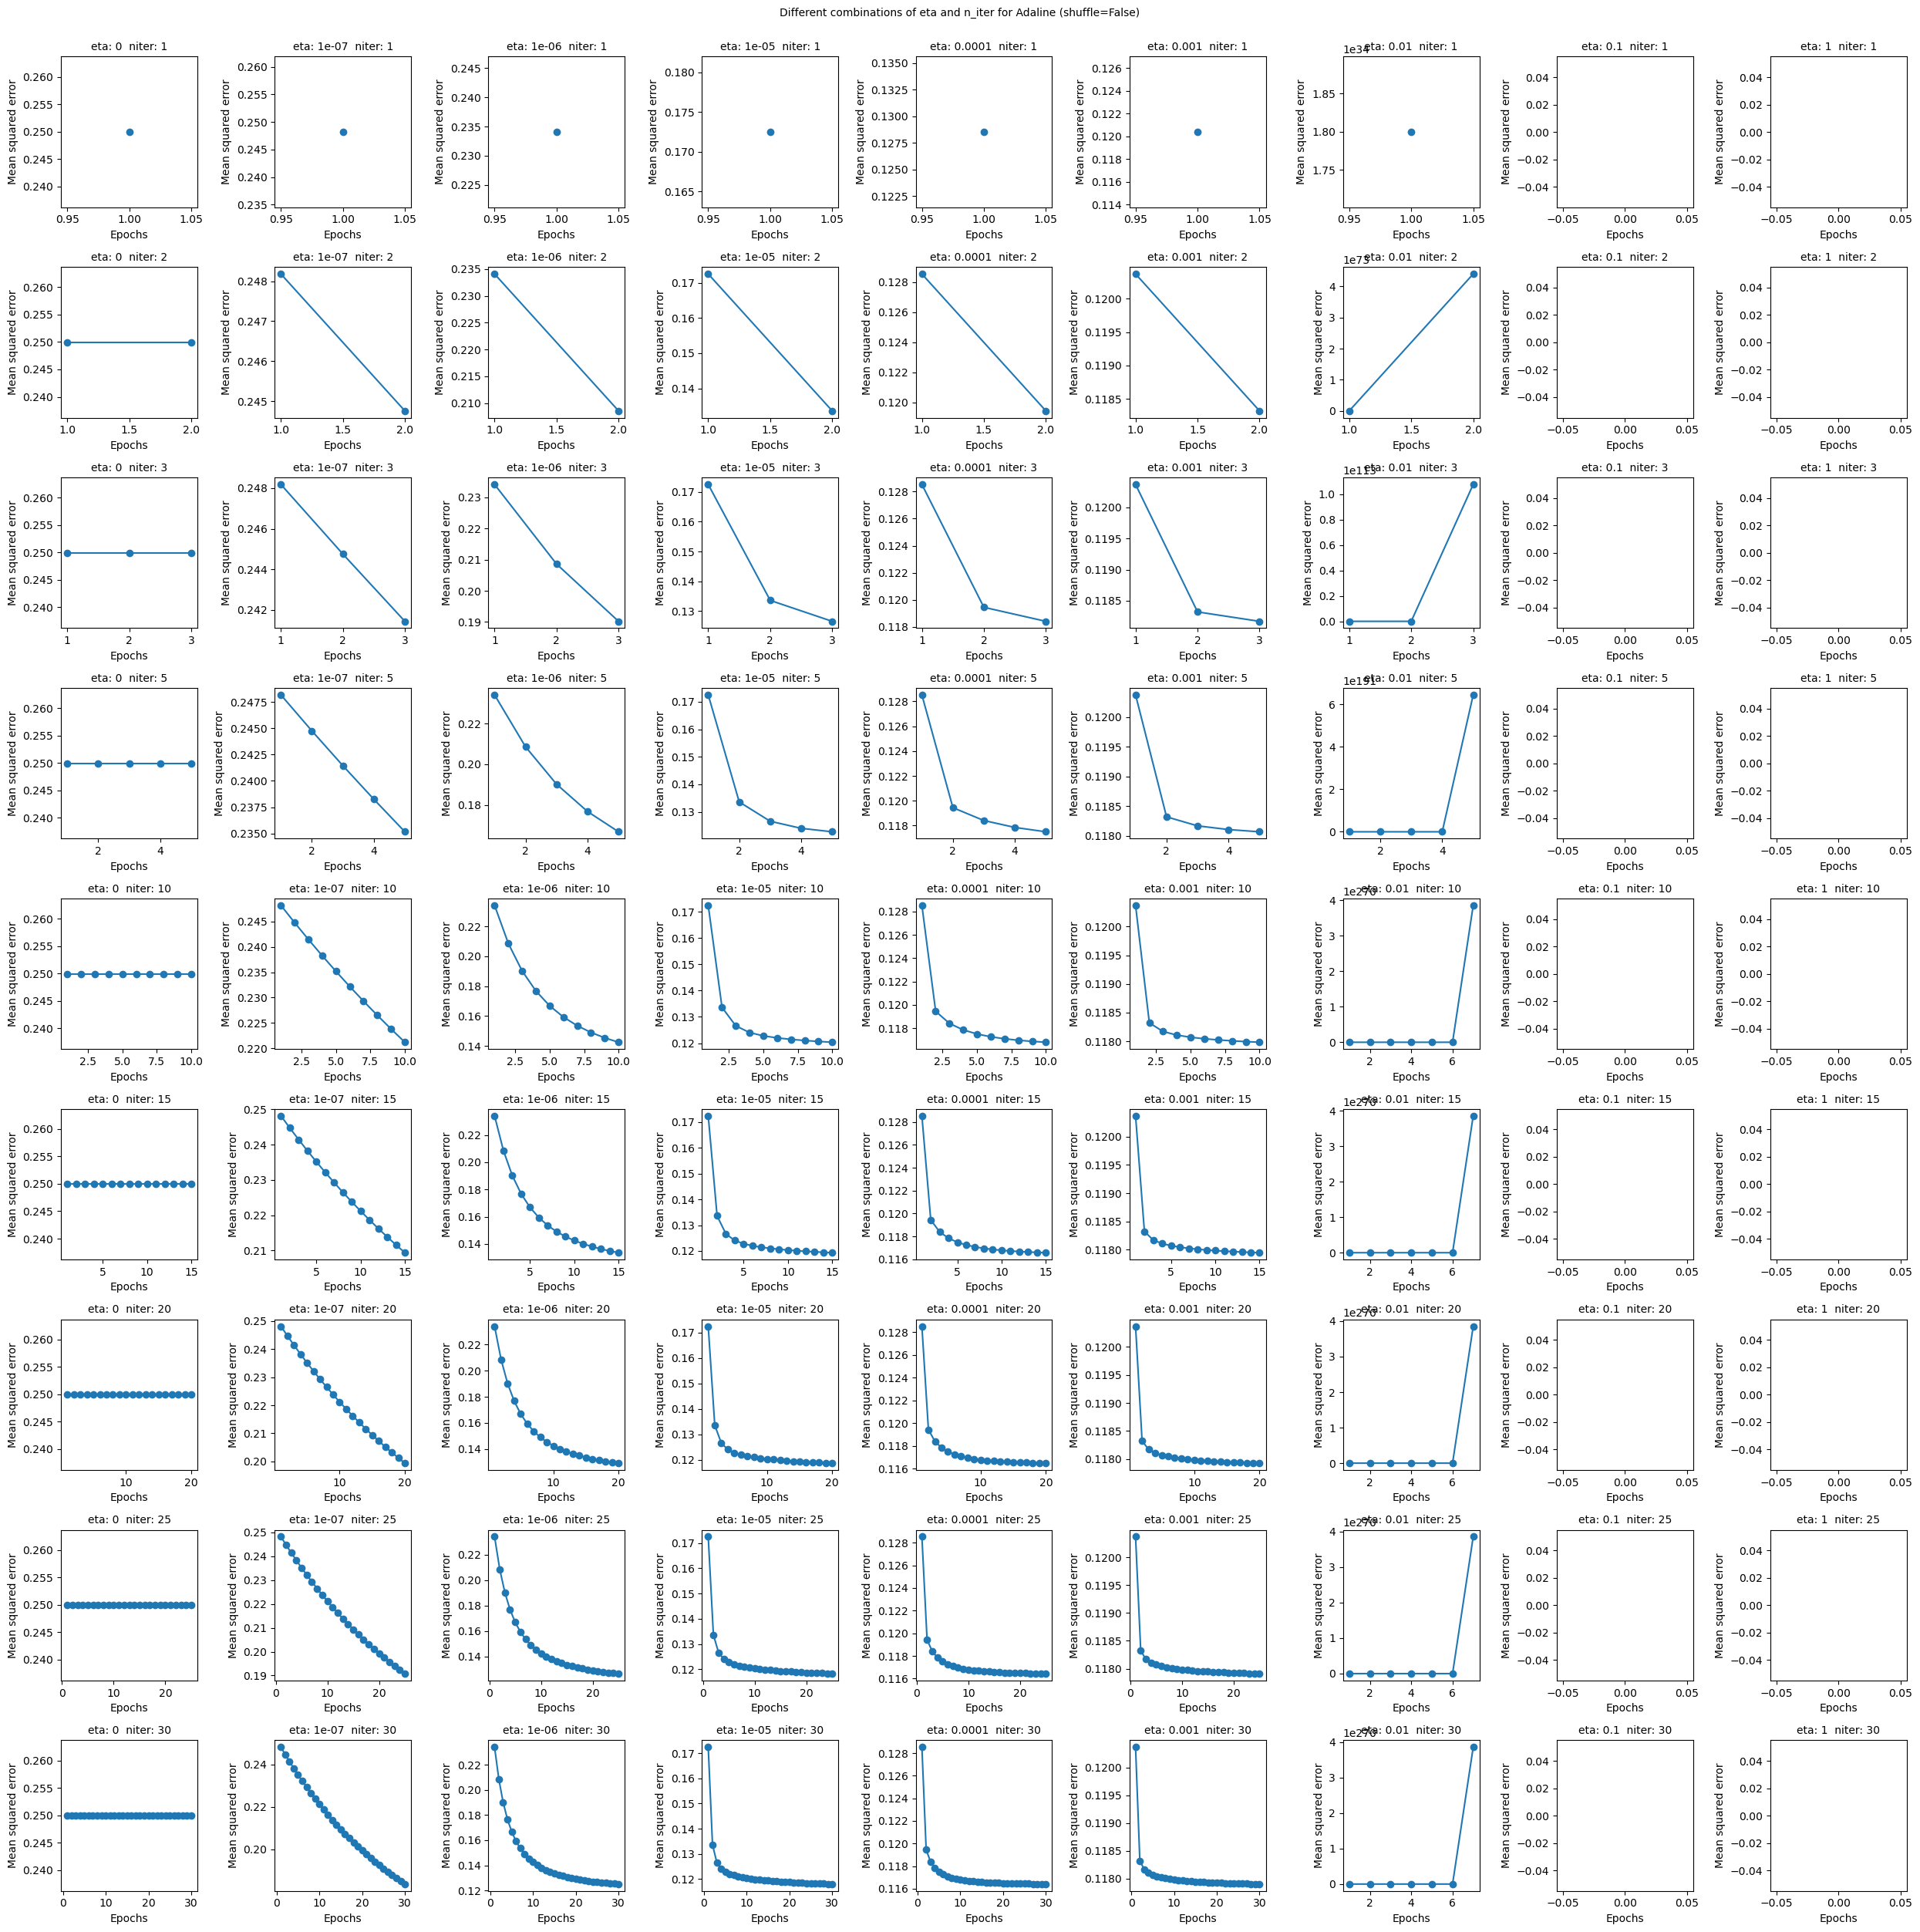

In [152]:
# Looking at parameters eta and n_iter when shuffle is false
fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(25, 25))

list_eta = [0, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
list_niter = [1, 2, 3, 5, 10, 15, 20, 25, 30]

fig.suptitle("Different combinations of eta and n_iter for Adaline (shuffle=False)", fontsize=10, y=1)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(n_iter=n_temp, eta= e_temp, shuffle=False, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        y_pred = ada.predict(X_test_adaline_col)
        #print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

plt.tight_layout()
plt.show()

C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:93: RuntimeWarning: overflow encountered in double_scalars
  loss = error**2
C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:98: RuntimeWarning: overflow encountered in double_scalars
  return np.dot(X, self.w_) + self.b_
C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:91: RuntimeWarning: invalid value encountered in multiply
  self.w_ += self.eta * 2.0 * xi * (error)
C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:91: RuntimeWarning: overflow encountered in multiply
  self.w_ += self.eta * 2.0 * xi * (error)
C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:91: RuntimeWarning: overflow encountered in add
  self.w_ += self.eta * 2.0 * xi * (error)
C:\Users\vicqd\AppData\Local\Temp\ipykernel_25516\1644968680.py:92: RuntimeWarning: overflow encountered in double_scalars
  self.b_ += self.eta * 2.0 * error


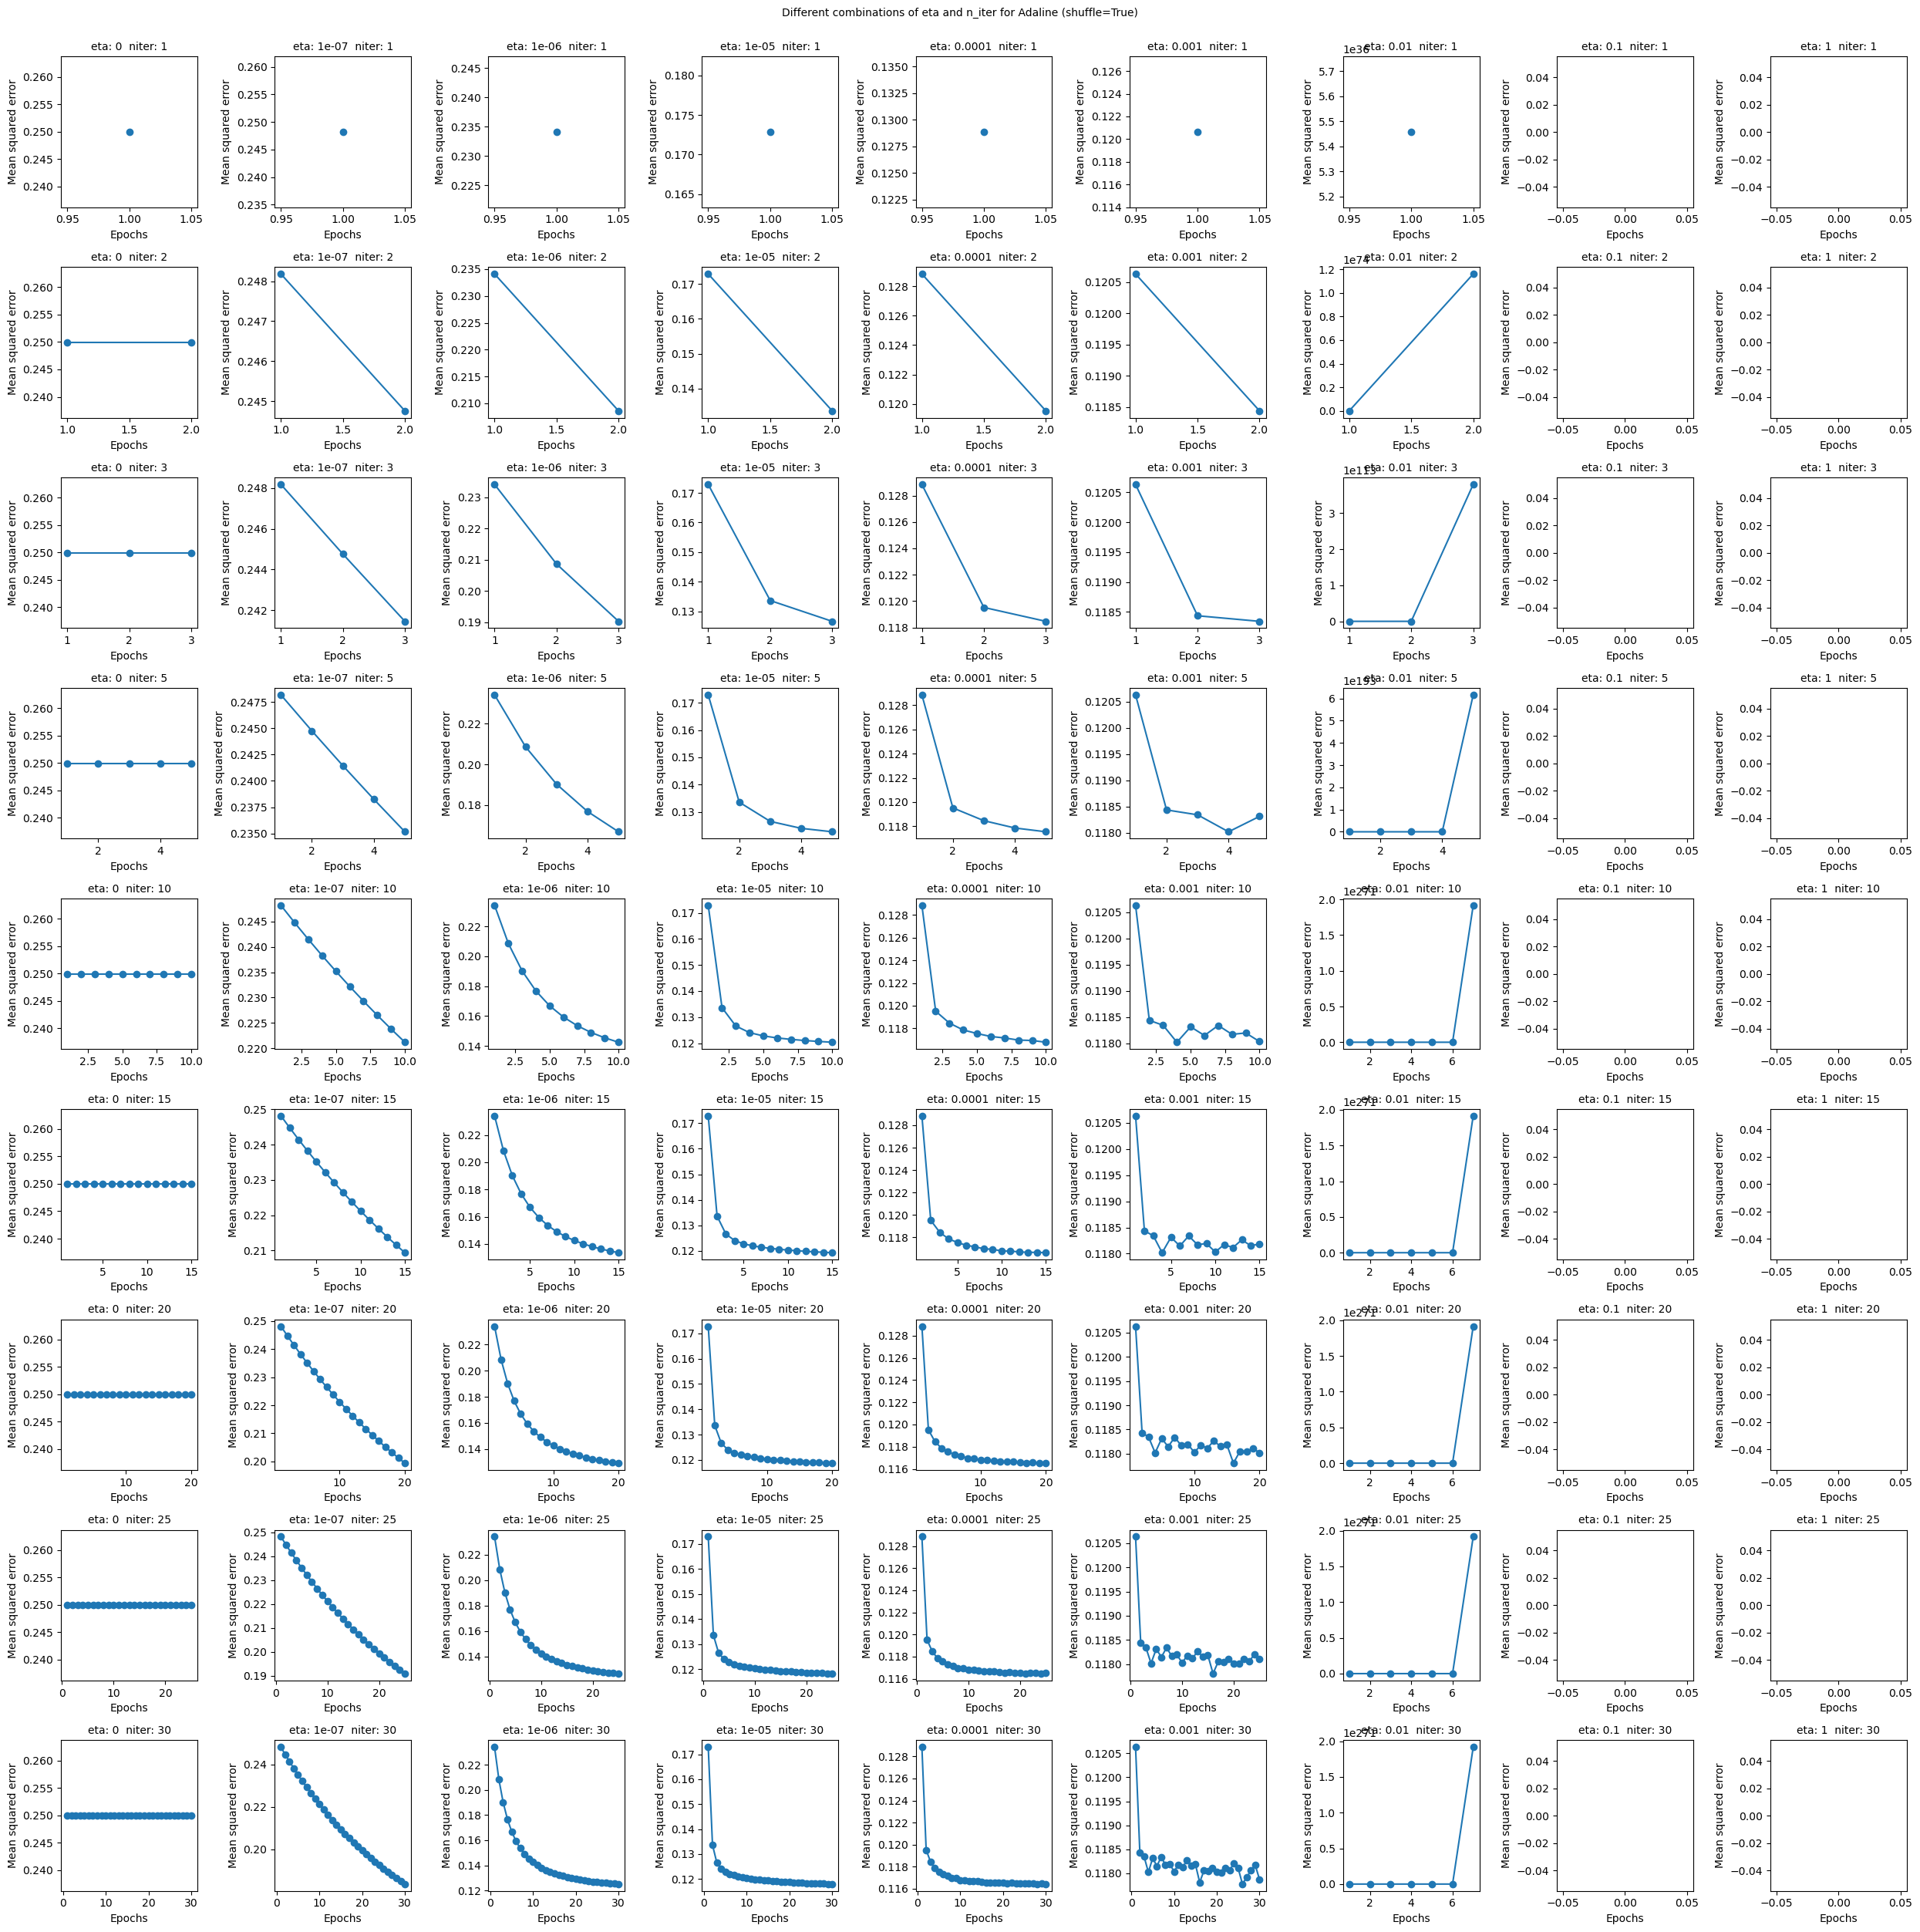

In [154]:
# Looking at parameters eta and n_iter when shuffle is true
fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(25, 25))

list_eta = [0, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
list_niter = [1, 2, 3, 5, 10, 15, 20, 25, 30]

fig.suptitle("Different combinations of eta and n_iter for Adaline (shuffle=True)", fontsize=10, y=1)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(n_iter=n_temp, eta= e_temp, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        y_pred = ada.predict(X_test_adaline_col)
        #$print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

plt.tight_layout()
plt.show()

In [155]:
# Compare the accuracy with eta 0.0001 and different n_iter

# n_iter 10
ada1 = AdalineSGD(n_iter=10, eta=0.0001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada1.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 10 and eta 0.0001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 15
ada2 = AdalineSGD(n_iter=15, eta=0.0001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada2.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 15 and eta 0.0001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 20
ada3 = AdalineSGD(n_iter=20, eta=0.0001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada3.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 20 and eta 0.0001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 25
ada4 = AdalineSGD(n_iter=25, eta=0.0001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada4.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 25 and eta 0.0001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 30
ada5 = AdalineSGD(n_iter=30, eta=0.0001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada5.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 30 and eta 0.0001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

Adaline accuracy with n_iter 10 and eta 0.0001: 0.8426
Adaline accuracy with n_iter 15 and eta 0.0001: 0.8415
Adaline accuracy with n_iter 20 and eta 0.0001: 0.8415
Adaline accuracy with n_iter 25 and eta 0.0001: 0.8417
Adaline accuracy with n_iter 30 and eta 0.0001: 0.8417


In [156]:
# Compare the accuracy with eta 0.00001 and different n_iter 

# n_iter 10
ada1 = AdalineSGD(n_iter=10, eta=0.00001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada1.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 10 and eta 0.0001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 15
ada2 = AdalineSGD(n_iter=15, eta=0.00001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada2.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 15 and eta 0.00001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 20
ada3 = AdalineSGD(n_iter=20, eta=0.00001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada3.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 20 and eta 0.00001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 25
ada4 = AdalineSGD(n_iter=25, eta=0.00001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada4.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 25 and eta 0.00001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

# n_iter 30
ada5 = AdalineSGD(n_iter=30, eta=0.00001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada5.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 30 and eta 0.00001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

Adaline accuracy with n_iter 10 and eta 0.0001: 0.8376
Adaline accuracy with n_iter 15 and eta 0.00001: 0.8403
Adaline accuracy with n_iter 20 and eta 0.00001: 0.8422
Adaline accuracy with n_iter 25 and eta 0.00001: 0.8432
Adaline accuracy with n_iter 30 and eta 0.00001: 0.8426


# (Adaline) Part 2b: Plot the MSE over epochs

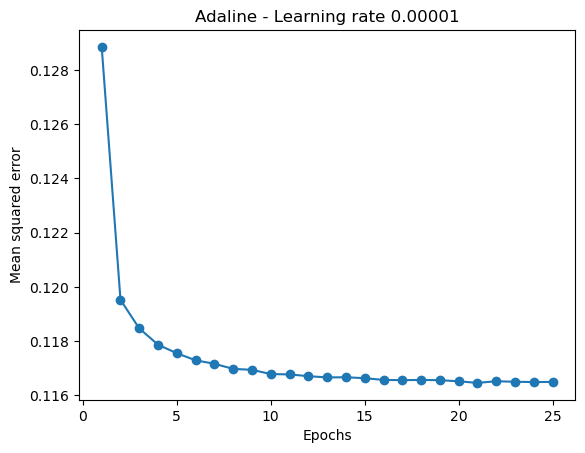

In [142]:
# Plot the MSE over epochs
plt.plot(range(1, len(ada4.losses_) + 1), ada4.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.title('Adaline - Learning rate 0.00001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

# (Adaline) Part 2c: Find the accuracy

In [159]:
ada4 = AdalineSGD(n_iter=25, eta=0.00001, shuffle=True, random_state=42).fit(X_train_adaline_col, y_train_adaline.loc[:,'income'].values)
y_pred =ada4.predict(X_test_adaline_col)
print(f"Adaline accuracy with n_iter 25 and eta 0.00001: {accuracy_score(y_test_adaline.loc[:,'income'].values, y_pred):.4f}")

Adaline accuracy with n_iter 25 and eta 0.00001: 0.8432


# (Adaline) Part 2d: Use best performing models to predict outputs for the validation

In [161]:
# Output the predictions for the validation
X_valid_pred_adaline = ada4.predict(X_valid_adaline_col)

In [ ]:
# Save validation prediction outputs to csv
#y_valid_pred_adaline_df = pd.DataFrame(X_valid_pred_adaline)
#y_valid_pred_adaline_df.to_csv("Group_10_Adaline_PredictedOutputs.csv")

# Part 2e

In [162]:
# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.000001, max_iter=15, random_state=42)
sk_ppn.fit(X_train_perceptron, y_train_perceptron)
sk_y_pred_ppn = sk_ppn.predict(X_test_perceptron)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test_perceptron, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.00001, learning_rate='constant', max_iter=25, random_state=42)
sk_ada.fit(X_train_adaline, y_train_adaline)
sk_y_pred_ada = sk_ada.predict(X_test_adaline)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test_adaline, sk_y_pred_ada):.4f}")

Scikit-learn Perceptron accuracy: 0.7685
Scikit-learn Adaline (SGDClassifier) accuracy: 0.6879


c:\Users\vicqd\anaconda3\envs\pyml-book\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Perceptron was fitted without feature names
  warnings.warn(
c:\Users\vicqd\anaconda3\envs\pyml-book\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [163]:
sk_y_pred_ppn_valid = sk_ppn.predict(X_valid_perceptron)
sk_y_pred_ada_valid = sk_y_pred_ada = sk_ada.predict(X_valid_adaline)

In [166]:
print(sk_y_pred_ada_valid)
print(sk_y_pred_ppn_valid)

[0 1 1 ... 1 0 0]
[0 1 1 ... 1 0 0]


In [167]:
# Save validation prediction outputs to csv
y_valid_pred_perceptron_df = pd.DataFrame(sk_y_pred_ppn_valid)
y_valid_pred_perceptron_df.to_csv("Group_10_Perceptron_PredictedOutputs.csv")

y_valid_pred_adaline_df = pd.DataFrame(sk_y_pred_ada_valid)
y_valid_pred_adaline_df.to_csv("Group_10_Adaline_PredictedOutputs.csv")